<a href="https://colab.research.google.com/github/ThuanPhong0126/CS114.K21/blob/master/Project/Untitled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Load Data

In [78]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [79]:
df=pd.read_excel('https://github.com/ThuanPhong0126/CS114.K21/blob/master/final_data.xlsx?raw=true')
df

,Unnamed: 0,text,label
0,0,Không có chào đón như trong giới thiệu,0
1,1,"Lựa chọn tốt cho du lịch nhóm ,gia đình",1
2,2,"phòng yên tĩnh dù sát mặt đường lớn , sạch sẽ.",1
3,3,phòng sạch đẹp,1
4,4,"Khách sạn sạch sẽ, gần biển, gần siêu thị Lott...",1
...,...,...,...
4119,145,Thôi thì treo biển không nhận khách đi oto cho...,0
4120,146,12 giờ đêm về thì khách sạn tối hin,0
4121,147,Nói 3 sao thì hơi quá.,0
4122,148,"Thua khách sạn mình ở Nha Trang, Vẫn 3 sao.",0


In [80]:
del df['Unnamed: 0']
df

,text,label
0,Không có chào đón như trong giới thiệu,0
1,"Lựa chọn tốt cho du lịch nhóm ,gia đình",1
2,"phòng yên tĩnh dù sát mặt đường lớn , sạch sẽ.",1
3,phòng sạch đẹp,1
4,"Khách sạn sạch sẽ, gần biển, gần siêu thị Lott...",1
...,...,...
4119,Thôi thì treo biển không nhận khách đi oto cho...,0
4120,12 giờ đêm về thì khách sạn tối hin,0
4121,Nói 3 sao thì hơi quá.,0
4122,"Thua khách sạn mình ở Nha Trang, Vẫn 3 sao.",0


In [81]:
X=df['text']
y=df['label']

In [82]:
X

0                  Không có chào đón như trong giới thiệu
1                Lựa chọn tốt cho du lịch nhóm ,gia đình 
2          phòng yên tĩnh dù sát mặt đường lớn , sạch sẽ.
3                                          phòng sạch đẹp
4       Khách sạn sạch sẽ, gần biển, gần siêu thị Lott...
                              ...                        
4119    Thôi thì treo biển không nhận khách đi oto cho...
4120                 12 giờ đêm về thì khách sạn tối hin 
4121                              Nói 3 sao thì hơi quá. 
4122          Thua khách sạn mình ở Nha Trang, Vẫn 3 sao.
4123    Vẫn nằm ở trục đường chính một chiều đông ngẹt...
Name: text, Length: 4124, dtype: object

In [83]:
y

0       0
1       1
2       1
3       1
4       1
       ..
4119    0
4120    0
4121    0
4122    0
4123    0
Name: label, Length: 4124, dtype: int64

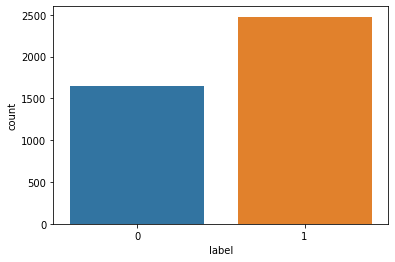

In [84]:
sns.countplot(df['label'])

In [85]:
!pip install pyvi

In [86]:
from pyvi import ViTokenizer
def Token(t):
  return ViTokenizer.tokenize(t)

def standardize_data(t):
  t = str(t)
  t = t.lower()
  t = t.replace(',', ' ').replace('.', ' ')\
      .replace(";", " ").replace("“", " ") \
      .replace(":", " ").replace("”", " ") \
      .replace('"', " ").replace("'", " ") \
      .replace("!", " ").replace("?", " ").replace("-", " ").replace("?", " ") 
  t = t.strip()
  return t

### Không phân tích theo nghĩa tiếng việt _ phân theo dấu cách

In [87]:
df['text'] = df['text'].apply(standardize_data)
df

,text,label
0,không có chào đón như trong giới thiệu,0
1,lựa chọn tốt cho du lịch nhóm gia đình,1
2,phòng yên tĩnh dù sát mặt đường lớn sạch sẽ,1
3,phòng sạch đẹp,1
4,khách sạn sạch sẽ gần biển gần siêu thị lott...,1
...,...,...
4119,thôi thì treo biển không nhận khách đi oto cho...,0
4120,12 giờ đêm về thì khách sạn tối hin,0
4121,nói 3 sao thì hơi quá,0
4122,thua khách sạn mình ở nha trang vẫn 3 sao,0



#### TF-IDF

In [88]:
X_train,X_test, y_train, y_test=train_test_split(df['text'],df['label'],test_size=0.2)
emb=TfidfVectorizer()
emb.fit(df['text'])
X_train=emb.transform(X_train)
X_test=emb.transform(X_test)

In [89]:
joblib.dump(emb, '/content/drive/My Drive/Colab Notebooks/ML/DoAnCuoiKy/tfidf_cach.pkl')

['/content/drive/My Drive/Colab Notebooks/ML/DoAnCuoiKy/tfidf_cach.pkl']

In [90]:
X_train

<3299x2490 sparse matrix of type '<class 'numpy.float64'>'
	with 43908 stored elements in Compressed Sparse Row format>

In [91]:
y_train

2719    1
882     1
2220    1
3922    0
3017    1
       ..
3210    1
756     1
240     0
455     0
1228    1
Name: label, Length: 3299, dtype: int64

##### Lựa chọn model

In [93]:
from sklearn.naive_bayes import BernoulliNB
model=BernoulliNB()
model.fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy:  ',accuracy_score(y_test,predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:   0.8812121212121212
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       350
           1       0.86      0.94      0.90       475

    accuracy                           0.88       825
   macro avg       0.89      0.87      0.88       825
weighted avg       0.88      0.88      0.88       825

[[280  70]
 [ 28 447]]


In [94]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.9309090909090909
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       350
           1       0.94      0.94      0.94       475

    accuracy                           0.93       825
   macro avg       0.93      0.93      0.93       825
weighted avg       0.93      0.93      0.93       825

[[321  29]
 [ 28 447]]


In [95]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier()
model.fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.9248484848484848
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       350
           1       0.93      0.94      0.94       475

    accuracy                           0.92       825
   macro avg       0.92      0.92      0.92       825
weighted avg       0.92      0.92      0.92       825

[[316  34]
 [ 28 447]]


In [96]:
from sklearn.svm import SVC
model=SVC()
model.fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.9490909090909091
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       350
           1       0.97      0.94      0.96       475

    accuracy                           0.95       825
   macro avg       0.95      0.95      0.95       825
weighted avg       0.95      0.95      0.95       825

[[335  15]
 [ 27 448]]


In [97]:
from sklearn.tree import DecisionTreeClassifier
model=DecisionTreeClassifier().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test,predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.8848484848484849
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       350
           1       0.89      0.91      0.90       475

    accuracy                           0.88       825
   macro avg       0.88      0.88      0.88       825
weighted avg       0.88      0.88      0.88       825

[[297  53]
 [ 42 433]]


 #### CountVectorizer

In [98]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [99]:
X=df['text']
y=df['label']
emb=CountVectorizer().fit(X)
X_train,X_test, y_train, y_test=train_test_split(X , y , test_size=0.2)
X_train=emb.transform(X_train)
X_test=emb.transform(X_test)

In [100]:
joblib.dump(emb, '/content/drive/My Drive/Colab Notebooks/ML/DoAnCuoiKy/countvr_cach.pkl')

['/content/drive/My Drive/Colab Notebooks/ML/DoAnCuoiKy/countvr_cach.pkl']

In [101]:
model=GaussianNB().fit(X_train.toarray(),y_train)
predict=model.predict(X_test.toarray())
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.7660606060606061
              precision    recall  f1-score   support

           0       0.83      0.52      0.64       328
           1       0.75      0.93      0.83       497

    accuracy                           0.77       825
   macro avg       0.79      0.72      0.73       825
weighted avg       0.78      0.77      0.75       825

[[170 158]
 [ 35 462]]


In [102]:
model=BernoulliNB().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.8581818181818182
              precision    recall  f1-score   support

           0       0.84      0.79      0.82       328
           1       0.87      0.90      0.88       497

    accuracy                           0.86       825
   macro avg       0.86      0.85      0.85       825
weighted avg       0.86      0.86      0.86       825

[[259  69]
 [ 48 449]]


In [103]:
model=SVC().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.9224242424242424
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       328
           1       0.95      0.92      0.93       497

    accuracy                           0.92       825
   macro avg       0.92      0.92      0.92       825
weighted avg       0.92      0.92      0.92       825

[[304  24]
 [ 40 457]]


In [104]:
model=RandomForestClassifier().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.926060606060606
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       328
           1       0.96      0.92      0.94       497

    accuracy                           0.93       825
   macro avg       0.92      0.93      0.92       825
weighted avg       0.93      0.93      0.93       825

[[308  20]
 [ 41 456]]


In [105]:
model=DecisionTreeClassifier().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.8884848484848484
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       328
           1       0.91      0.91      0.91       497

    accuracy                           0.89       825
   macro avg       0.88      0.88      0.88       825
weighted avg       0.89      0.89      0.89       825

[[282  46]
 [ 46 451]]


In [106]:
model=LogisticRegression().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.9478787878787879
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       328
           1       0.95      0.96      0.96       497

    accuracy                           0.95       825
   macro avg       0.95      0.94      0.95       825
weighted avg       0.95      0.95      0.95       825

[[305  23]
 [ 20 477]]


### Pyvi

In [107]:
df['text'] = df['text'].apply(standardize_data)
df['text'] = df['text'].apply(Token)
df

,text,label
0,không có chào_đón như trong giới_thiệu,0
1,lựa_chọn tốt cho du_lịch nhóm gia_đình,1
2,phòng yên_tĩnh dù sát mặt_đường lớn sạch_sẽ,1
3,phòng sạch đẹp,1
4,khách_sạn sạch_sẽ gần biển gần siêu_thị lotte ...,1
...,...,...
4119,thôi_thì treo biển không nhận khách đi oto cho...,0
4120,12 giờ đêm về thì khách_sạn tối hin,0
4121,nói 3 sao thì hơi quá,0
4122,thua khách_sạn mình ở nha trang vẫn 3 sao,0


#### TF-IDF

In [108]:
emb=TfidfVectorizer().fit(df['text'])

In [109]:
joblib.dump(emb, '/content/drive/My Drive/Colab Notebooks/ML/DoAnCuoiKy/tfidf_pyvi.pkl')

['/content/drive/My Drive/Colab Notebooks/ML/DoAnCuoiKy/tfidf_pyvi.pkl']

In [110]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2)

In [111]:
X_train=emb.transform(X_train)
X_test=emb.transform(X_test)

In [112]:
X_train

<3299x3212 sparse matrix of type '<class 'numpy.float64'>'
	with 34783 stored elements in Compressed Sparse Row format>

In [113]:
from sklearn.naive_bayes import BernoulliNB
model=BernoulliNB()
model.fit(X_train,y_train)
predict=model1.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test, predict))
print(confusion_matrix(y_test, predict))

Accuracy:  0.9187878787878788
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       327
           1       0.90      0.97      0.94       498

    accuracy                           0.92       825
   macro avg       0.93      0.90      0.91       825
weighted avg       0.92      0.92      0.92       825

[[274  53]
 [ 14 484]]


In [114]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.9515151515151515
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       327
           1       0.95      0.97      0.96       498

    accuracy                           0.95       825
   macro avg       0.95      0.95      0.95       825
weighted avg       0.95      0.95      0.95       825

[[303  24]
 [ 16 482]]


In [115]:
from sklearn.svm import SVC
model=SVC().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.9575757575757575
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       327
           1       0.97      0.96      0.96       498

    accuracy                           0.96       825
   macro avg       0.96      0.96      0.96       825
weighted avg       0.96      0.96      0.96       825

[[310  17]
 [ 18 480]]


In [116]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.9490909090909091
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       327
           1       0.96      0.96      0.96       498

    accuracy                           0.95       825
   macro avg       0.95      0.95      0.95       825
weighted avg       0.95      0.95      0.95       825

[[306  21]
 [ 21 477]]


In [117]:
from sklearn.tree import DecisionTreeClassifier
model=DecisionTreeClassifier().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.9103030303030303
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       327
           1       0.92      0.93      0.93       498

    accuracy                           0.91       825
   macro avg       0.91      0.90      0.91       825
weighted avg       0.91      0.91      0.91       825

[[287  40]
 [ 34 464]]


#### CountVecterizer

In [118]:
from sklearn.feature_extraction.text import CountVectorizer

In [119]:
X_train, X_test, y_train, y_test = train_test_split( df['text'], df['label'], test_size=0.2)

In [120]:
emb=CountVectorizer().fit(df['text'])

X_train=emb.transform(X_train)
X_test=emb.transform(X_test)

In [121]:
joblib.dump(emb, '/content/drive/My Drive/Colab Notebooks/ML/DoAnCuoiKy/Count_pyvi.pkl')

['/content/drive/My Drive/Colab Notebooks/ML/DoAnCuoiKy/Count_pyvi.pkl']

In [122]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB

In [123]:
model=BernoulliNB().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.8775757575757576
              precision    recall  f1-score   support

           0       0.91      0.78      0.84       332
           1       0.86      0.95      0.90       493

    accuracy                           0.88       825
   macro avg       0.88      0.86      0.87       825
weighted avg       0.88      0.88      0.88       825

[[258  74]
 [ 27 466]]


In [124]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.9454545454545454
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       332
           1       0.95      0.96      0.95       493

    accuracy                           0.95       825
   macro avg       0.95      0.94      0.94       825
weighted avg       0.95      0.95      0.95       825

[[305  27]
 [ 18 475]]


In [125]:
from sklearn.svm import SVC
model=SVC().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.9309090909090909
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       332
           1       0.94      0.94      0.94       493

    accuracy                           0.93       825
   macro avg       0.93      0.93      0.93       825
weighted avg       0.93      0.93      0.93       825

[[304  28]
 [ 29 464]]


In [126]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.9296969696969697
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       332
           1       0.94      0.94      0.94       493

    accuracy                           0.93       825
   macro avg       0.93      0.93      0.93       825
weighted avg       0.93      0.93      0.93       825

[[304  28]
 [ 30 463]]


In [127]:
from sklearn.tree import DecisionTreeClassifier
model=DecisionTreeClassifier().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.8872727272727273
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       332
           1       0.90      0.92      0.91       493

    accuracy                           0.89       825
   macro avg       0.88      0.88      0.88       825
weighted avg       0.89      0.89      0.89       825

[[279  53]
 [ 40 453]]


### Dự đoán một câu mới được nhập vào
Nếu nhập vào comment gồm nhiều câu sẽ được tách thành các câu riêng rồi dự đoán trên mỗi câu

In [ ]:
comment=input()
feature=pd.Series(comment.split('.'))
feature = feature.apply(standardize_data)
feature = feature.apply(Token)
feature=emb.transform(feature)
predict=model.predict(feature)
print(predict)

Khách sạn quá tệ nhưng bù lại nằm ở vị trí trung tâm
[0]


In [76]:
from pyvi import ViTokenizer
def Token(t):
  return ViTokenizer.tokenize(t)

print(Token('Khách sạn nằm tại trung tâm thành phố'))

Khách_sạn nằm tại trung_tâm thành_phố
